# 2023 Immune dataset H3K27me3 noise - added control

Data:
https://www.encodeproject.org/immune-cells/?type=Experiment&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_ontology.cell_slims=hematopoietic+cell&biosample_ontology.classification=primary+cell&control_type!=*&status!=replaced&status!=revoked&status!=archived&biosample_ontology.system_slims=immune+system&biosample_ontology.system_slims=circulatory+system&config=immune

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

## Load peaks

In [3]:
PATH = os.path.expanduser('~/data/2023_Immune_noise')
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K27me3']

! mkdir -p {PATH}/pics

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        # print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr


In [5]:
def load_peaks(path):
    df_fdr_macs2 = load_peaks_fdr(os.path.join(path, 'macs2'), '.narrowPeak', ['0.05'])
    df_fdr_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_fdr_macs2))

    df_fdr_macs2broad = load_peaks_fdr(os.path.join(path, 'macs2'), '.broadPeak', ['0.1'])
    df_fdr_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_fdr_macs2broad))

    df_fdr_sicer = load_peaks_fdr(os.path.join(path, 'sicer'), 'summary-FDR', ['0.01'])
    df_fdr_sicer['tool'] = 'SICER'
    print('SICER', len(df_fdr_sicer))

    df_fdr_span = load_peaks_fdr(os.path.join(path, 'span'), '.peak', ['0.05'])
    df_fdr_span['tool'] = 'SPAN'
    print('SPAN', len(df_fdr_span))

    return pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span]).reset_index(drop=True)

In [6]:
df_fdr_peaks_noise = load_peaks(PATH)
df_fdr_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1]:
    df_fdr_peaks_noise.loc[[f'_{mln}mln' in file for file in df_fdr_peaks_noise['file']], 'quality'] = mln
df_fdr_original_peaks = load_peaks(os.path.expanduser('~/data/2023_Immune'))
df_fdr_original_peaks['quality'] = 20
df_fdr_peaks = pd.concat([df_fdr_peaks_noise, df_fdr_original_peaks]).reset_index(drop=True)

  0%|          | 0/560 [00:00<?, ?it/s]

MACS2 15


  0%|          | 0/560 [00:00<?, ?it/s]

MACS2 broad 15


  0%|          | 0/71 [00:00<?, ?it/s]

SICER 15


  0%|          | 0/73 [00:00<?, ?it/s]

SPAN 15


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 3


In [7]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number and lengths

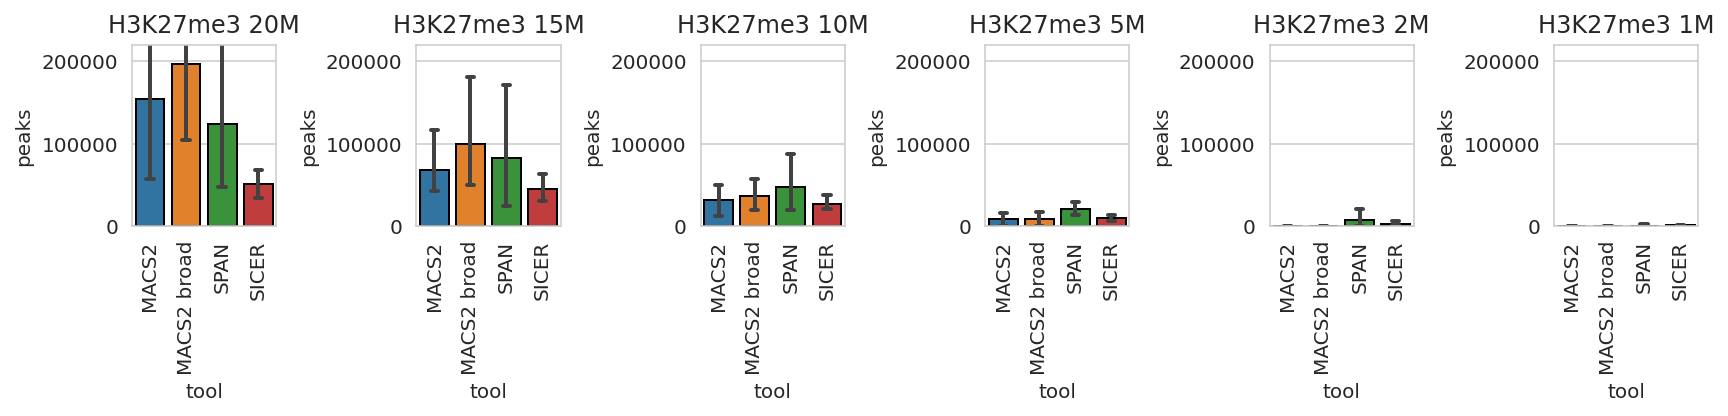

In [8]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]

for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=df_fdr_peaks[df_fdr_peaks['quality']==mln],
                            x='tool', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.set_ylim(0, 220_000)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(f'H3K27me3 {mln}M')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

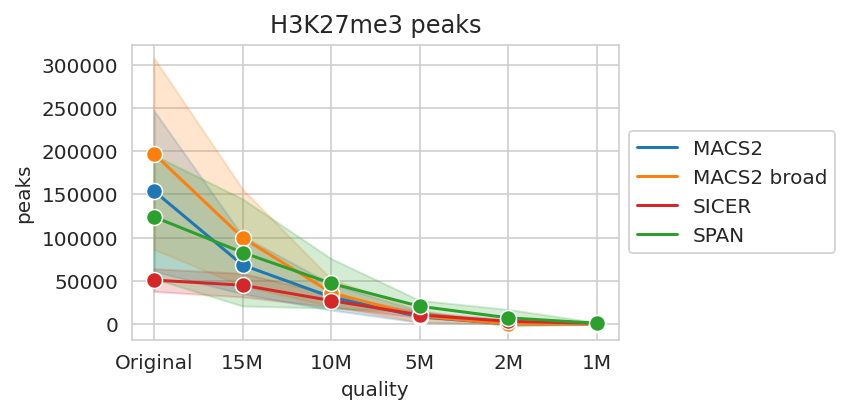

In [9]:
df_fdr_peaks['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    df_fdr_peaks.loc[df_fdr_peaks['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=df_fdr_peaks,
                         x='q', y='peaks', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar=('sd', 0.8), marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K27me3 peaks')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_peaks2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
ts = []
for mln, file, tool in tqdm(zip(df_fdr_peaks['quality'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000))
    t['quality'] = mln
    t['name'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,quality,name
99645,1124.0,10,MACS2 broad
194291,5999.0,1,SICER
123013,281.0,10,MACS2 broad
113363,569.0,10,MACS2 broad
17945,308.0,15,MACS2
454609,490.0,20,SPAN
155961,214.0,5,MACS2 broad
136050,1826.0,15,MACS2 broad
147131,272.0,15,MACS2 broad
337362,2394.0,5,SPAN


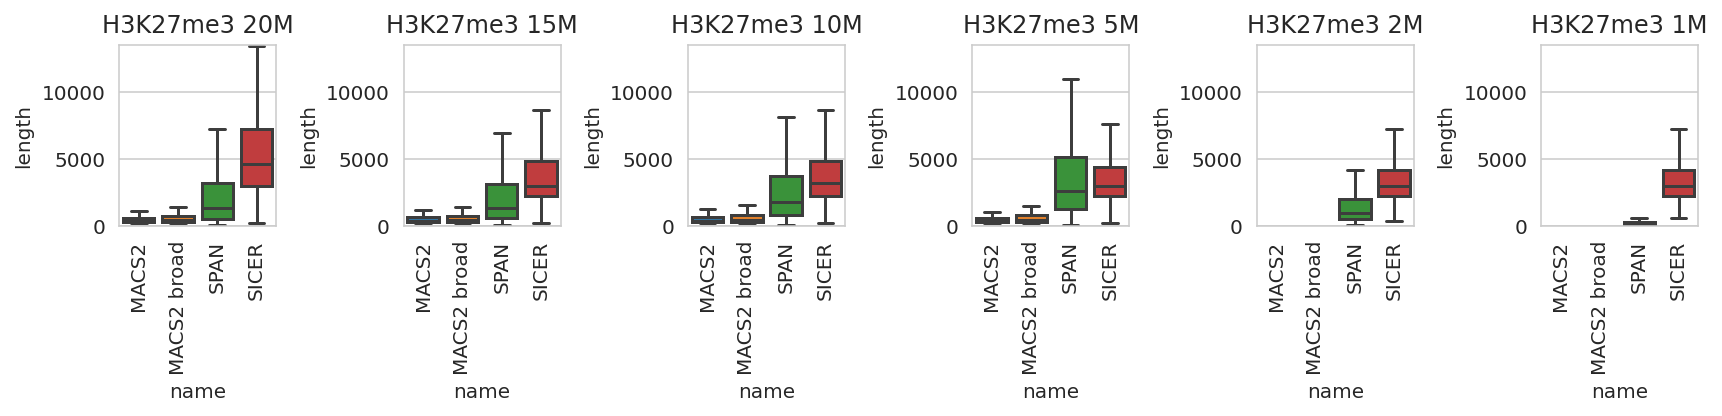

In [11]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.boxplot(data=t[t['quality']==mln], x='name', y='length', ax=ax,
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            showfliers=False)
    ax.title.set_text(f'H3K27me3 {mln}M')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim([-10, 13_500])
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

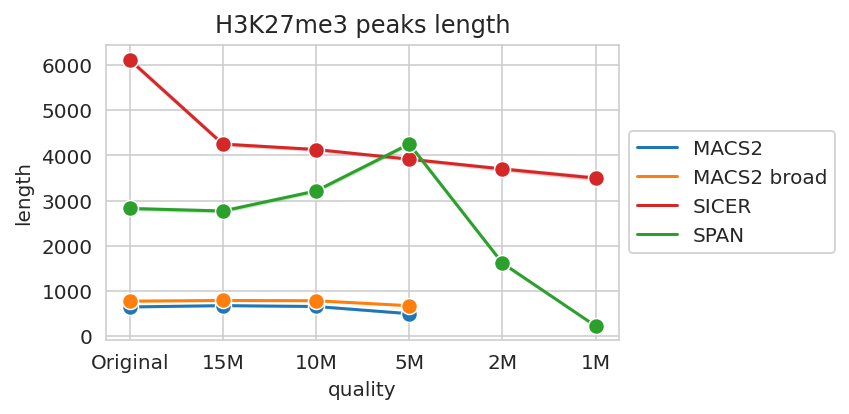

In [12]:
t['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='length', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K27me3 peaks length')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_lengths2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Footprint

In [13]:
ts = []
for mln, file, tool in tqdm(zip(df_fdr_peaks['quality'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    ts.append((mln, tool, coverage))
t = pd.DataFrame(data=ts, columns=['quality', 'name', 'coverage'])
del ts
t.sample(1)

0it [00:00, ?it/s]

,quality,name,coverage
6,15,MACS2,44912981.0


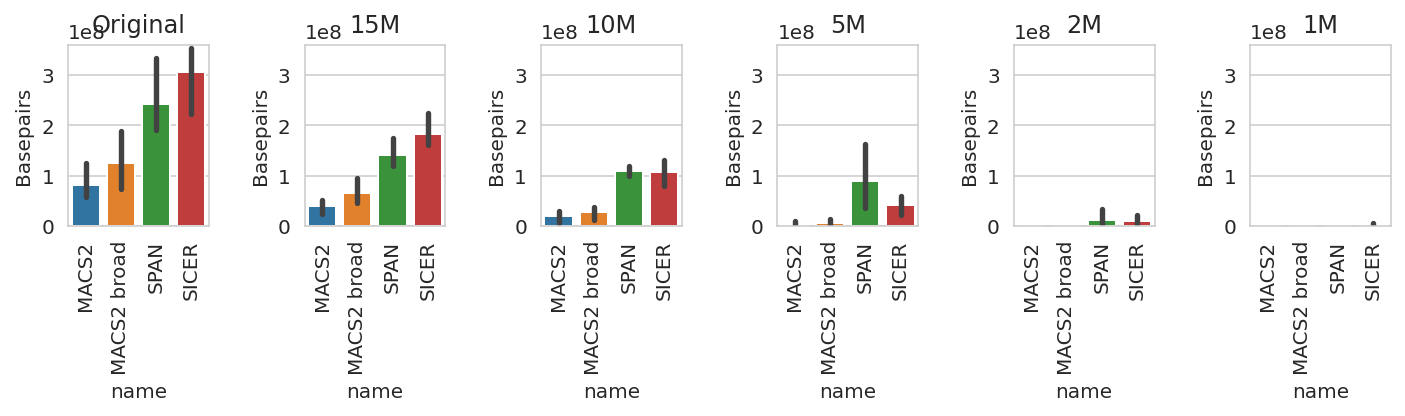

In [14]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=t[t['quality']==mln], x='name', y='coverage', ax=ax,
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')
    ax.set_ylabel('Basepairs')
    ax.set_ylim([0, 3.6e8])
    ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

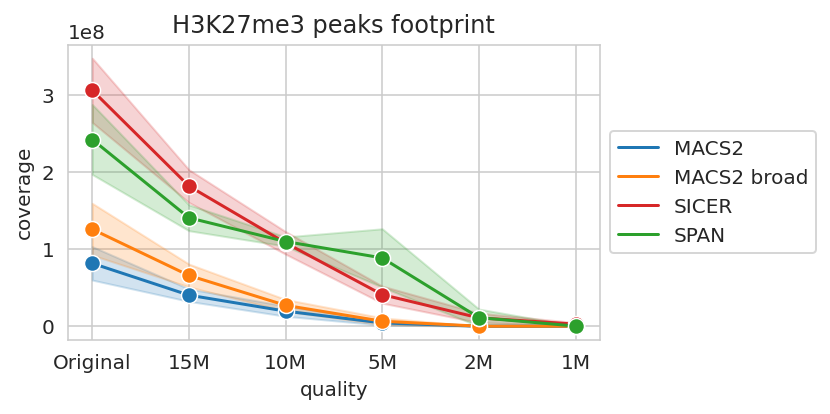

In [15]:
t['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='coverage', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K27me3 peaks footprint')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_sumlength2.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Jaccard vs original peaks

In [16]:
import tempfile
from itertools import product

mln_bench_df = pd.DataFrame(
    columns=['cell', 'name', 'full_peaks', 'full_peaks_len',
             'quality', 'mln_peaks', 'mln_peaks_len',
             'full_overlap', 'mln_overlap',
             'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for c, tool in tqdm(product(IMMUNE_CELLS, TOOLS)):
    print(c, tool)
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                     (df_fdr_peaks['modification'] == 'H3K27me3') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['quality'] == 20)]
    if len(t) == 0:
        continue
    full_file = sorted_file(t['file'].values[0])
    full_peaks = lines(full_file)
    full_peaks_len = int(bedl(full_file).sum())
    for mln in [15, 10, 5, 2, 1]:
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['quality'] == mln)]
        if len(t) == 0:
            continue
        mln_file = sorted_file(t['file'].values[0])
        mln_peaks = lines(mln_file)
        mln_peaks_len = int(bedl(mln_file).sum())
        !bedtools intersect -a {full_file} -b {mln_file} -wa -u > {tf}
        full_peaks_overlap = lines(tf)
        !bedtools intersect -b {full_file} -a {mln_file} -wa -u > {tf}
        mln_peaks_overlap = lines(tf)
        !bedtools intersect -a {full_file} -b {mln_file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        mln_bench_df.loc[len(mln_bench_df)] = \
            (c, tool,
             full_peaks, full_peaks_len,
             mln, mln_peaks, mln_peaks_len,
             full_peaks_overlap, mln_peaks_overlap,
             overlap_len)

display(mln_bench_df.sample())

0it [00:00, ?it/s]

BCell MACS2
BCell MACS2 broad
BCell SPAN
BCell SICER
TCell MACS2
TCell MACS2 broad
TCell SPAN
TCell SICER
Monocyte MACS2
Monocyte MACS2 broad
Monocyte SPAN
Monocyte SICER


,cell,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len
44,Monocyte,MACS2,57580,57137110,1,0,0,0,0,0


In [17]:
mln_bench_df['precision'] = [d(a, b) for a, b in zip(mln_bench_df['mln_overlap'], mln_bench_df['mln_peaks'])]
mln_bench_df['sensitivity'] = [d(a, b) for a, b in zip(mln_bench_df['full_overlap'], mln_bench_df['full_peaks'])]
mln_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(mln_bench_df['sensitivity'], mln_bench_df['precision'])]

mln_bench_df['precision_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['mln_peaks_len'])]
mln_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(mln_bench_df['overlap_len'], mln_bench_df['full_peaks_len'])]
mln_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                          for s, p in zip(mln_bench_df['sensitivity_len'], mln_bench_df['precision_len'])]

mln_bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(mln_bench_df['full_peaks_len'], mln_bench_df['mln_peaks_len'], mln_bench_df['overlap_len'])
]
mln_bench_df.sample(1)

,cell,name,full_peaks,full_peaks_len,quality,mln_peaks,mln_peaks_len,full_overlap,mln_overlap,overlap_len,precision,sensitivity,f1,precision_len,sensitivity_len,f1_len,jaccard
52,Monocyte,SPAN,47143,203461471,5,12916,68228391,11284,12912,67963868,0.99969,0.239357,0.386237,0.996123,0.334038,0.500305,0.333604


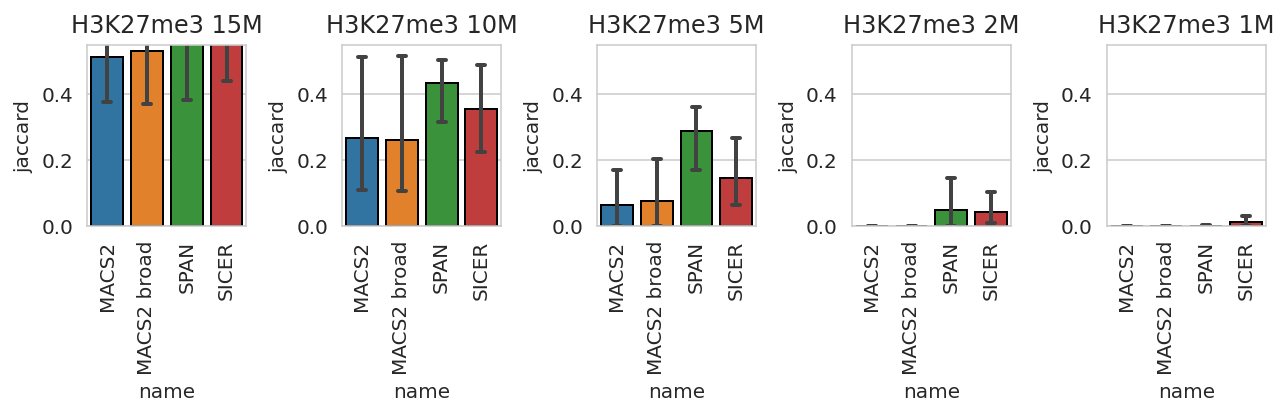

In [18]:
plt.figure(figsize=(9, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, mln in enumerate([15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=mln_bench_df[mln_bench_df['quality']==mln],
                            x='name', y='jaccard', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.title.set_text(f'H3K27me3 {mln}M')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim([0, 0.55])
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

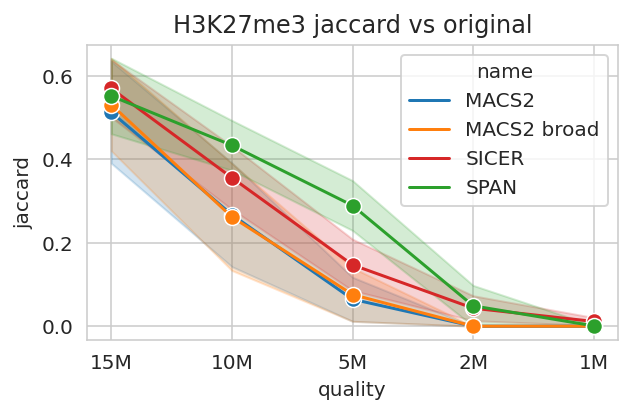

In [19]:
mln_bench_df['q'] = 0
for i, mln in enumerate([15, 10, 5, 2, 1]):
    mln_bench_df.loc[mln_bench_df['quality'] == mln, 'q'] = i

plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=mln_bench_df,
                         x='q', y='jaccard', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(5), minor=False)
g_results.axes.set_xticklabels(['15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.title.set_text(f'H3K27me3 jaccard vs original')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_jaccard2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
mln_bench_df['modification'] = 'H3K27me3'
mln_bench_df.to_csv(PATH + '/H3K27me3_mln_bench_df.csv.gz', index=False, compression='gzip')

## Average precision
AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

0it [00:00, ?it/s]

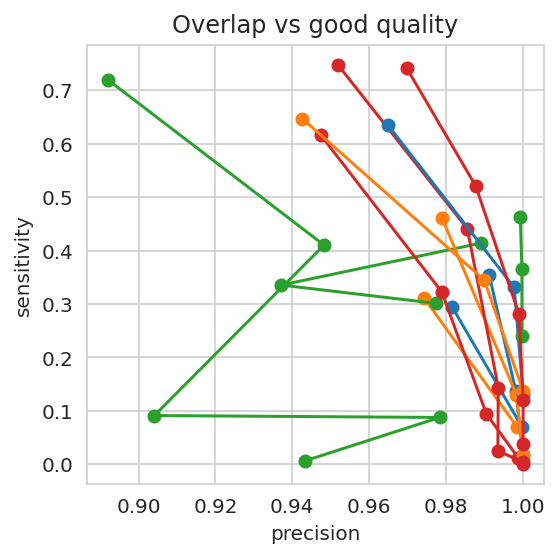

In [21]:
plt.figure(figsize=(4, 4))
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    # print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity'] + dft['precision'] > 0]
    dft.sort_values(by=['sensitivity', 'quality'], inplace=True)
    plt.plot(dft['precision'], dft['sensitivity'], marker='o', label=tool, color=TOOLS_PALETTE[tool])
plt.title('Overlap vs good quality')
plt.xlabel('precision')
plt.ylabel('sensitivity')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

0it [00:00, ?it/s]

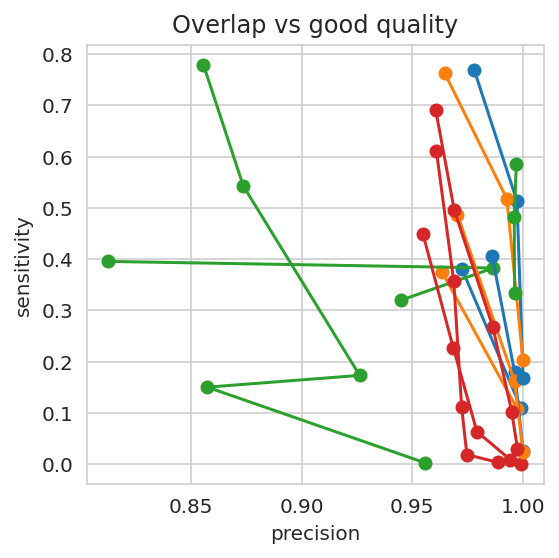

In [22]:
plt.figure(figsize=(4, 4))
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    # print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity_len'] + dft['precision_len'] > 0]
    dft.sort_values(by=['sensitivity_len', 'quality'], inplace=True)
    plt.plot(dft['precision_len'], dft['sensitivity_len'], marker='o', label=tool, color=TOOLS_PALETTE[tool])
plt.title('Overlap vs good quality')
plt.xlabel('precision')
plt.ylabel('sensitivity')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_auc_len.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [23]:
t = []
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity'] + dft['precision'] > 0]
    dft.sort_values(by=['sensitivity', 'quality'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - rprev) * row['precision']
        rprev = row['sensitivity']
    t.append((c, tool, ap))
dfap = pd.DataFrame(data=t, columns=['cell', 'tool', 'AP'])
dfap

0it [00:00, ?it/s]

BCell MACS2
BCell MACS2 broad
BCell SPAN
BCell SICER
TCell MACS2
TCell MACS2 broad
TCell SPAN
TCell SICER
Monocyte MACS2
Monocyte MACS2 broad
Monocyte SPAN
Monocyte SICER


,cell,tool,AP
0,BCell,MACS2,0.289700
1,BCell,MACS2 broad,0.304896
2,BCell,SPAN,0.404224
3,BCell,SICER,0.594503
4,TCell,MACS2,0.352814
5,TCell,MACS2 broad,0.453967
6,TCell,SPAN,0.667270
7,TCell,SICER,0.727938
8,Monocyte,MACS2,0.623731
9,Monocyte,MACS2 broad,0.627594


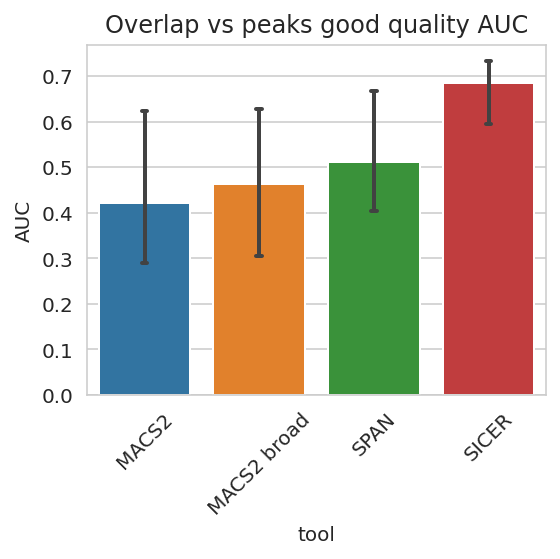

In [24]:
fig = plt.figure(figsize=(4, 4))
g_result = sns.barplot(data=dfap, x="tool", y="AP", capsize=.05, errwidth=2)
g_result.axes.xaxis.set_tick_params(rotation=45)
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs peaks good quality AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_ap.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [25]:
t = []
for c, tool in tqdm(product(mln_bench_df['cell'].unique(), mln_bench_df['name'].unique())):
    # print(c, tool)
    dft = mln_bench_df[(mln_bench_df['cell'] == c) & (mln_bench_df['name'] == tool)].copy()
    dft = dft[dft['sensitivity_len'] + dft['precision_len'] > 0]
    dft.sort_values(by=['sensitivity_len', 'quality'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity_len'] - rprev) * row['precision_len']
        rprev = row['sensitivity_len']
    t.append((c, tool, ap))
dfapl = pd.DataFrame(data=t, columns=['cell', 'tool', 'APL'])
dfapl

0it [00:00, ?it/s]

,cell,tool,APL
0,BCell,MACS2,0.373018
1,BCell,MACS2 broad,0.364742
2,BCell,SPAN,0.374543
3,BCell,SICER,0.431540
4,TCell,MACS2,0.402767
5,TCell,MACS2 broad,0.476105
6,TCell,SPAN,0.675387
7,TCell,SICER,0.590424
8,Monocyte,MACS2,0.762114
9,Monocyte,MACS2 broad,0.752119


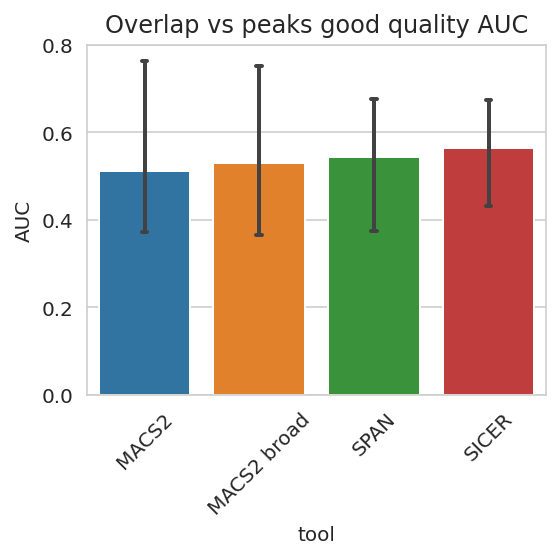

In [26]:
fig = plt.figure(figsize=(4, 4))
g_result = sns.barplot(data=dfapl, x="tool", y="APL", capsize=.05, errwidth=2)
g_result.axes.xaxis.set_tick_params(rotation=45)
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs peaks good quality AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_apl.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Overlap H3K27me3

In [27]:
import tempfile
tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name', 'peaks', 'peaks_len'],
    dtype=object
)

ts = []
for mln, c in tqdm(product([20, 15, 10, 5, 2, 1], IMMUNE_CELLS)):
    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ts.append((c, mln, tool, peaks, peaks_len))
        if tool == 'SPAN':
            span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            ts.append((c, mln, name, peaks, peaks_len))

bench_df = pd.DataFrame(data=ts, columns=['cell', 'quality', 'name', 'peaks', 'length'])
del ts
bench_df.sample(3)

0it [00:00, ?it/s]

,cell,quality,name,peaks,length
18,TCell,20,SPAN - SICER,71154,19227212
24,Monocyte,20,SPAN - MACS2,28433,57298973
7,BCell,20,MACS2 broad - SPAN,14774,4478611


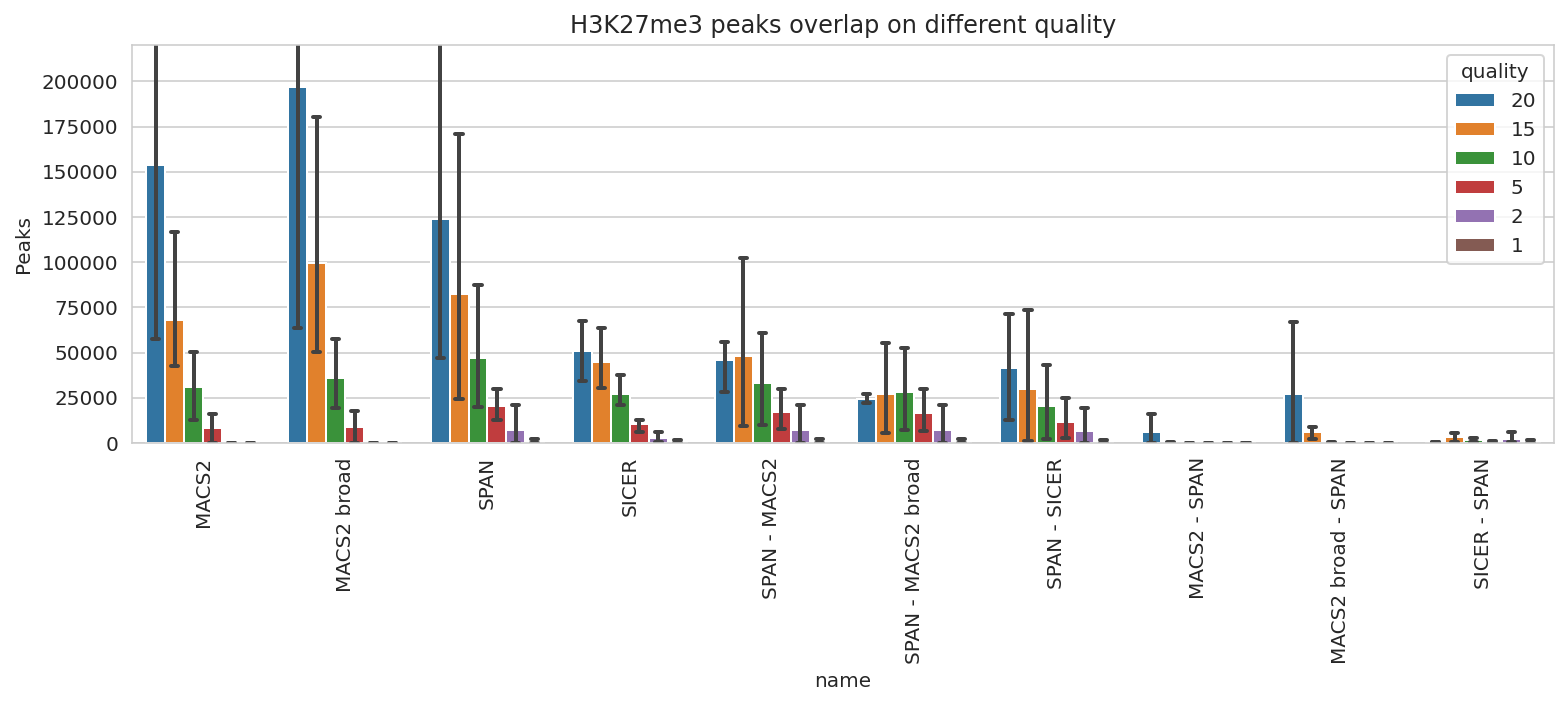

In [28]:
plt.figure(figsize=(11, 5))
ax = plt.axes()
g_results = sns.barplot(data=bench_df, hue='quality',
                        x='name', y='peaks', ax=ax,
                        hue_order=[20, 15, 10, 5, 2, 1],
                        capsize=.05, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.title.set_text('H3K27me3 peaks overlap on different quality')
ax.set_ylabel('Peaks')
ax.set_ylim([0, 220_000])
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_overlap.pdf', bbox_inches='tight', dpi=300)
plt.show()

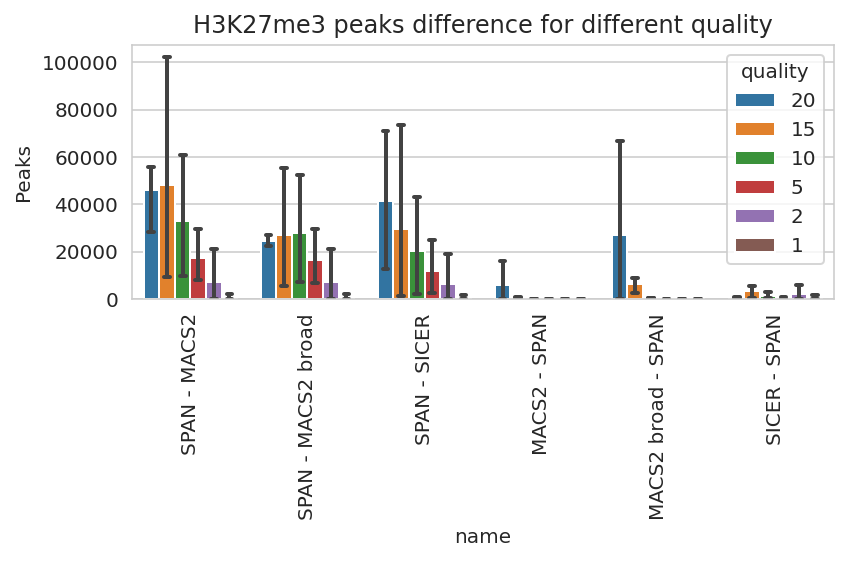

In [29]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=bench_df, hue='quality',
                        x='name', y='peaks', ax=ax,
                        hue_order=[20, 15, 10, 5, 2, 1],
                        capsize=.05, errwidth=2,
                        order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.title.set_text('H3K27me3 peaks difference for different quality')
ax.set_ylabel('Peaks')
# ax.set_ylim([0, 20_000])
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_overlap_diff.pdf', bbox_inches='tight', dpi=300)
plt.show()

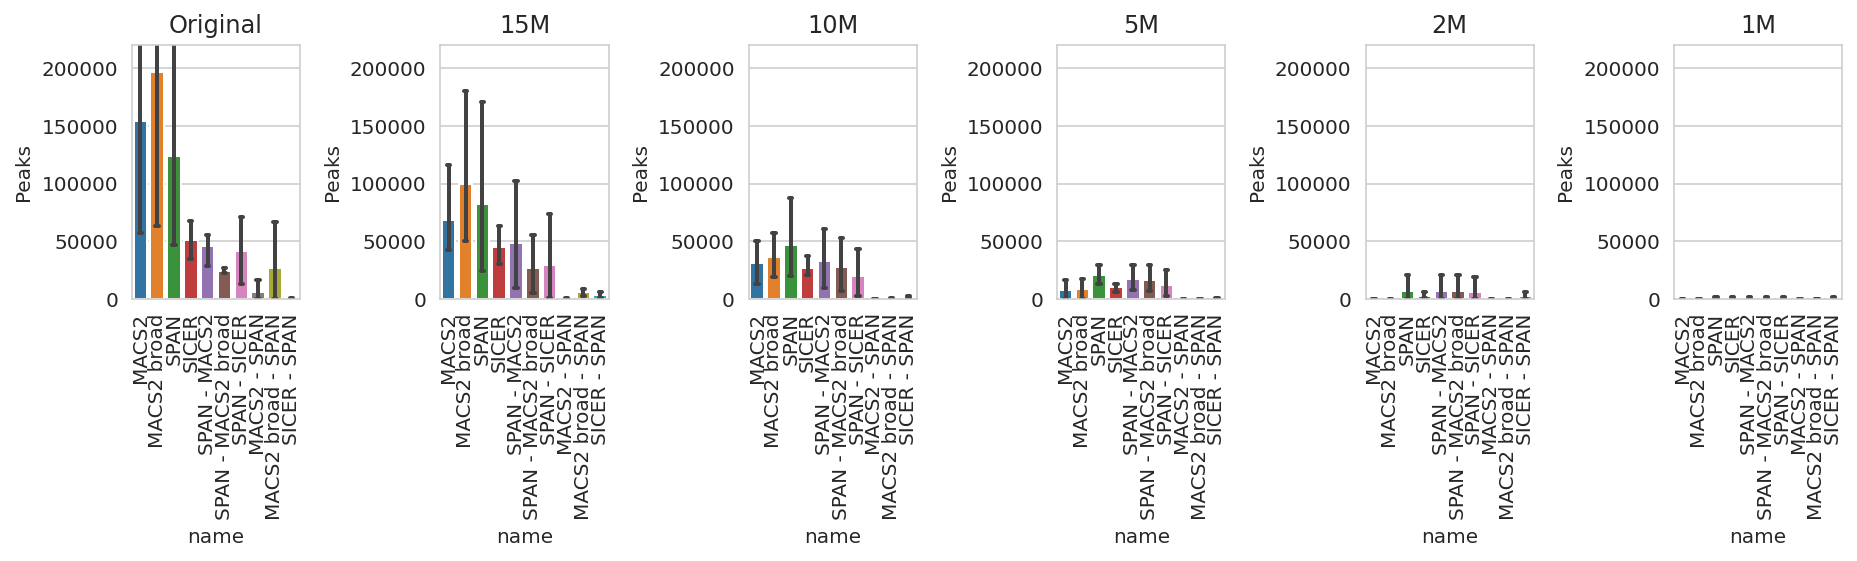

In [30]:
plt.figure(figsize=(13, 4))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['quality']==mln],
                            x='name', y='peaks', ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ])
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')
    ax.set_ylabel('Peaks')
    ax.set_ylim([0, 220_000])
    ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_overlap_2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Coverage

In [31]:
# Fraction of reads in peaks
IMMUNE_HG38_PATH_BW = os.path.expanduser('~/data/2023_Immune') + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        if cell and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell)
    return df_bws

In [32]:
bws_df = load_bws(IMMUNE_HG38_PATH_BW, 'H3K27me3')
display(bws_df.sample(2))
bws_control_df = load_bws(IMMUNE_HG38_PATH_BW, 'Control')
display(bws_control_df.sample(2))

  0%|          | 0/26 [00:00<?, ?it/s]

,file,modification,cell
2,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,H3K27me3,Monocyte
1,/home/jetbrains/data/2023_Immune/bw/TCell_H3K2...,H3K27me3,TCell


  0%|          | 0/26 [00:00<?, ?it/s]

,file,modification,cell
0,/home/jetbrains/data/2023_Immune/bw/TCell_Cont...,Control,TCell
2,/home/jetbrains/data/2023_Immune/bw/BCell_Cont...,Control,BCell


In [33]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

In [34]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for mln, c in tqdm(product([20, 15, 10, 5, 2, 1], IMMUNE_CELLS)):
    print(mln, c)
    t = bws_df[(bws_df['modification'] == 'H3K27me3') &
               (bws_df['cell'] == c)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[bws_control_df['cell'] == c]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]

    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27me3', mln, c, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27me3', mln, c, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27me3', mln, c, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27me3', mln, c, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'quality', 'cell', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

20 BCell
20 TCell
20 Monocyte
15 BCell
15 TCell
15 Monocyte
10 BCell
10 TCell
10 Monocyte
5 BCell
5 TCell
5 Monocyte
2 BCell
2 TCell
2 Monocyte
1 BCell
1 TCell
1 Monocyte


,modification,quality,cell,name,position,length,type,coverage,total_coverage
7264005,H3K27me3,10,TCell,SPAN - MACS2,chr1:160112700-160113799,1099,treatment,2798.0,2.170976e+09
4781440,H3K27me3,15,TCell,MACS2,chr20:51229965-51230249,284,control,18.0,2.998567e+09
722748,H3K27me3,20,BCell,SPAN,chr1:75067845-75068378,533,control,366.0,2.477712e+09
1830205,H3K27me3,20,TCell,MACS2 broad,chr11:75596256-75596906,650,treatment,2206.0,2.170726e+09
7423518,H3K27me3,10,TCell,SPAN - MACS2 broad,chr6:282512-283384,872,treatment,2648.0,2.170976e+09


In [35]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

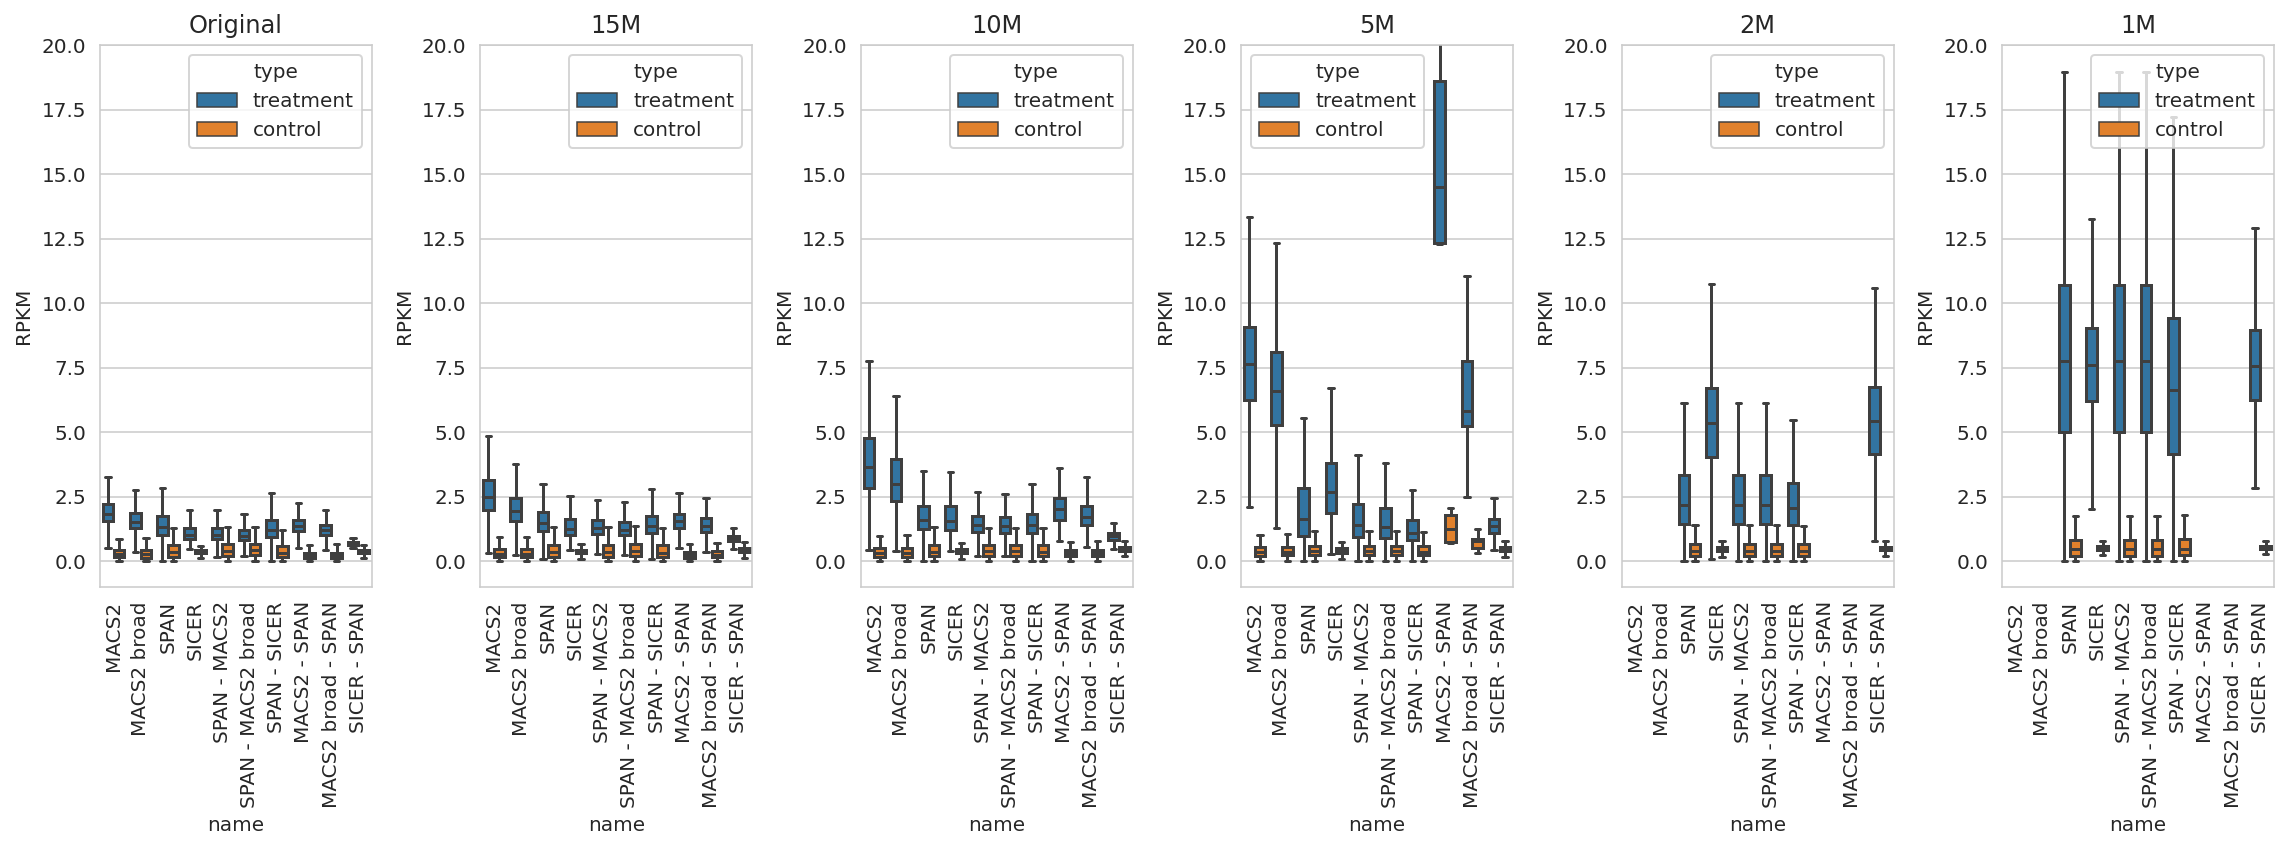

In [36]:
plt.figure(figsize=(16, 6))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    ax = axs[i]
    g_results = sns.boxplot(data=df_coverage[df_coverage['quality'] == mln],
                            x='name', y='rpkm', hue='type',
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ],
                            showfliers=False, ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('RPKM')
    ax.set_ylim(-1, 20)
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')

plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

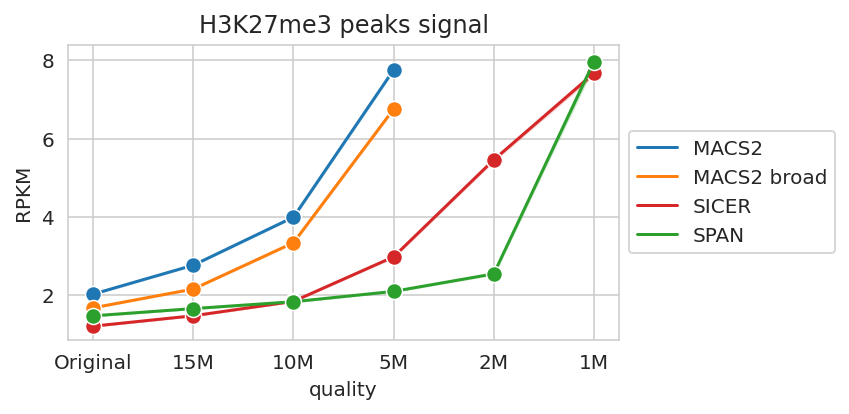

In [37]:
t = df_coverage[(df_coverage['name'].isin(['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])) &
                (df_coverage['type'] == 'treatment')].copy()
t['q'] = 0
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    t.loc[t['quality'] == mln, 'q'] = i

plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t,
                         x='q', y='rpkm', hue='name',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.set_xticks(range(6), minor=False)
g_results.axes.set_xticklabels(['Original', '15M', '10M', '5M', '2M', '1M'])
g_results.axes.set_xlabel('quality')
g_results.axes.set_ylabel('RPKM')
g_results.axes.title.set_text(f'H3K27me3 peaks signal')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_coverage2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [38]:
CHROMHMM_MAP = {
    'BCell': os.path.expanduser('~/data/2023_Immune') + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': os.path.expanduser('~/data/2023_Immune') + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': os.path.expanduser('~/data/2023_Immune') + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [39]:
import tempfile

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for mln, c in tqdm(product([20, 15, 10, 5, 2, 1], IMMUNE_CELLS)):
    print(mln, c)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in TOOLS:
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, mln, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['quality'] == mln) &
                         (df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, mln, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'quality', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

0it [00:00, ?it/s]

20 BCell
20 TCell
20 Monocyte
15 BCell
15 TCell
15 Monocyte
10 BCell
10 TCell
10 Monocyte
5 BCell
5 TCell
5 Monocyte
2 BCell
2 TCell
2 Monocyte
1 BCell
1 TCell
1 Monocyte


,cell,quality,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,BCell,20,MACS2,120947,49,3,15712,53,3,1561,...,104498,66212,14,4740,884,507,103,403,224,0
1,BCell,20,MACS2 broad,187656,118,21,14306,100,3,3964,...,148072,128117,39,4451,1541,983,221,1090,844,0
2,BCell,20,SPAN,102270,311,50,9520,116,4,6149,...,68783,68096,105,3538,2070,1537,408,1988,1855,0
3,BCell,20,SICER,50127,333,63,8775,97,6,5050,...,41689,41515,215,3336,2182,1528,498,1725,1653,0
4,BCell,20,SPAN - MACS2,53861,141,26,355,49,2,2524,...,26832,26793,30,47,565,481,150,958,892,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Monocyte,1,MACS2 - SPAN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176,Monocyte,1,SPAN - MACS2 broad,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,Monocyte,1,MACS2 broad - SPAN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,Monocyte,1,SPAN - SICER,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


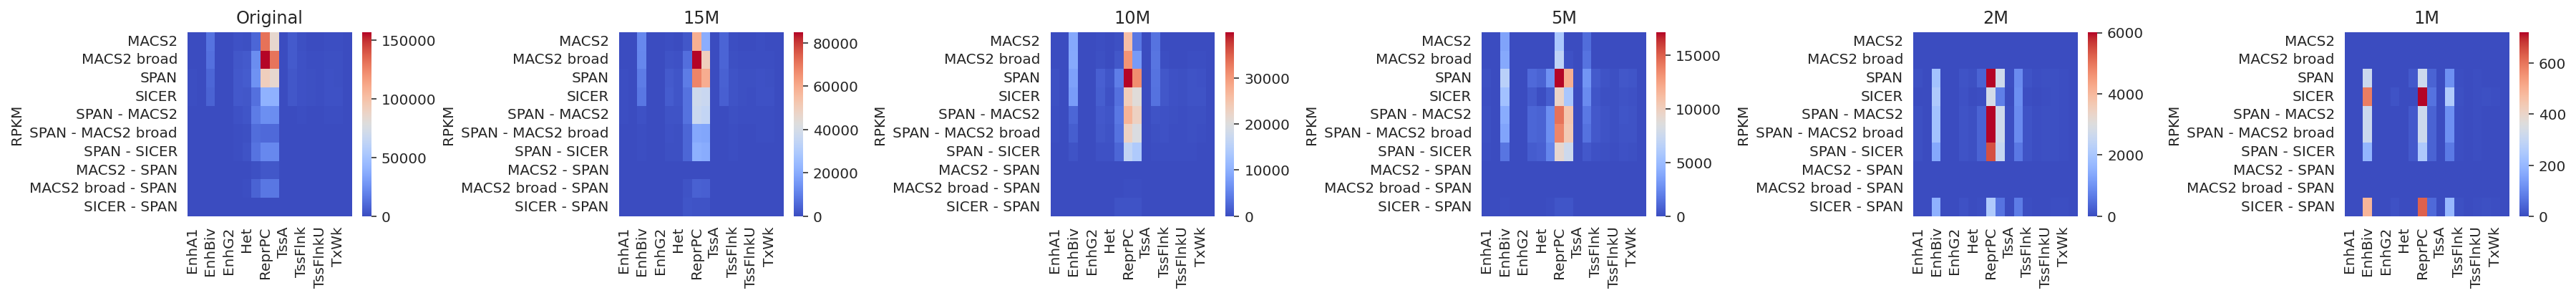

In [40]:
plt.figure(figsize=(25, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, mln in enumerate([20, 15, 10, 5, 2, 1]):
    chromhmm_qual_df = chromhmm_df[chromhmm_df['quality'] == mln]
    chrommm_df_mean = chromhmm_qual_df[['name'] + CHROMM_STATES].groupby('name').mean()
    chrommm_df_mean = chrommm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                       ]]
    ax = axs[i]
    sns.heatmap(chrommm_df_mean, cmap='coolwarm', ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('RPKM')
    # ax.set_ylim(-1, 85)
    ax.title.set_text(f'{mln}M' if mln != 20 else 'Original')

plt.tight_layout()
plt.savefig(f'{PATH}/pics/H3K27me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()